In [29]:
import pandas as pd

original = pd.read_csv('data.csv')

df = pd.read_csv('data.csv')


In [30]:
unknown_smokers = (original['smoking_status'] == 'Unknown').sum()

# Smoking status as unknown is still useful for analysis - who is not willing to disclose?
print(f"Number of 'Unknown' smoking_status: {unknown_smokers}\n")

print(original.isna().sum())

# Clean the Data
df['bmi'] = df['bmi'].fillna(df['bmi'].median()) #median is better than mean for skewed data like BMI

Number of 'Unknown' smoking_status: 1544

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [31]:
# Preprocessing

#Drop the ID Category
df.drop('id', axis=1, inplace=True)

# Male = 0, Female = 1 (Binary encoding)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})


# Married yes = 1, Married NO = 0
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

# Work Type: Private = 0, Self-employed = 1, Gov. Job = 2, Children = 3, Never Worked = 4
work_types = {
    'Private': 0,
    'Self-employed': 1,
    'Govt_job': 2,
    'children': 3,
    'Never_worked': 4
}
df['work_type'] = df['work_type'].map(work_types)


# Residence Type: Urban = 1, Rural = 0
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# Smoking_status 
df['smoking_status'] = df['smoking_status'].map({
    'formerly smoked': 0,
    'never smoked': 1,
    'smokes': 2,
    'Unknown': 3
})

In [32]:
print(df)

      gender   age  hypertension  heart_disease  ever_married  work_type  \
0        0.0  67.0             0              1             1          0   
1        1.0  61.0             0              0             1          1   
2        0.0  80.0             0              1             1          0   
3        1.0  49.0             0              0             1          0   
4        1.0  79.0             1              0             1          1   
...      ...   ...           ...            ...           ...        ...   
5105     1.0  80.0             1              0             1          0   
5106     1.0  81.0             0              0             1          1   
5107     1.0  35.0             0              0             1          1   
5108     0.0  51.0             0              0             1          0   
5109     1.0  44.0             0              0             1          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0              

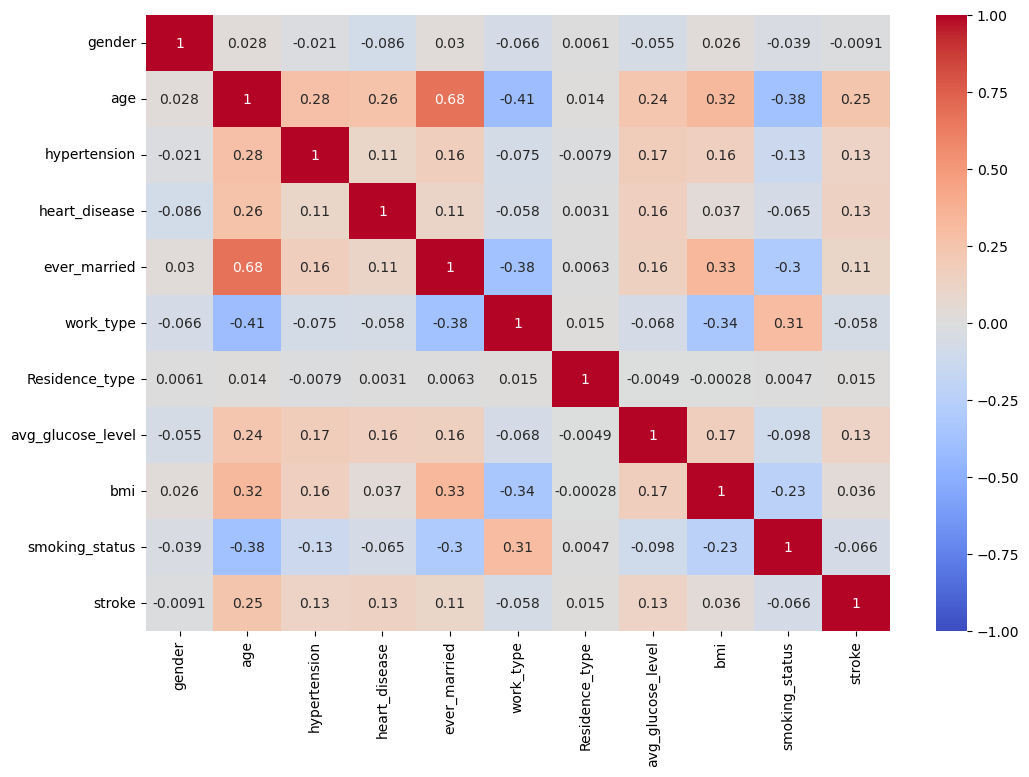

In [33]:
# Statistics on our data

corr_matrix = df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()


In [35]:
# Split into training and test data 

df = df.dropna() #drop the one "Other"

from sklearn.model_selection import train_test_split

# Step 1: Separate features (X) and target (y)
X = df.drop('stroke', axis=1)


y = df['stroke']

In [36]:
# Count how many had a stroke (1) and how many didn’t (0)
print(df['stroke'].value_counts())
print(df['stroke'].value_counts(normalize=True))  # percentages

0    4860
1     249
Name: stroke, dtype: int64
0    0.951262
1    0.048738
Name: stroke, dtype: float64


In [38]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

# Assuming your data is in 'X' and target variable 'y'

# Train-test split (if you haven't split it yet)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Deal with imbalanced data using SMOTE
sm = SMOTE(random_state=42)

# Check class distribution before resampling
print("Before resampling:", Counter(y_train))

# Apply SMOTE
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("After resampling:", Counter(y_train_resampled))

# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "NeuralNetwork (MLP)": MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(50,), solver='adam', activation='relu')
   
}

# Initialize a dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    if model_name == "Logistic Regression":
        # Create DataFrame of features and coefficients
        coef_df = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_[0],
            'Odds Ratio': np.exp(model.coef_[0])
        }).sort_values(by='Coefficient', key=abs, ascending=False)

        print("\nLogistic Regression Coefficients and Odds Ratios:")
        print(coef_df)


    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = accuracy
    
    # Print confusion matrix and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Compare the accuracy of each model
print("\nModel Comparison:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")


Before resampling: Counter({0: 4140, 1: 202})
After resampling: Counter({0: 4140, 1: 4140})

Training Logistic Regression...

Logistic Regression Coefficients and Odds Ratios:
             Feature  Coefficient  Odds Ratio
4       ever_married    -1.255477    0.284940
3      heart_disease    -1.112779    0.328644
6     Residence_type    -1.031300    0.356543
2       hypertension    -0.956649    0.384178
5          work_type    -0.655357    0.519257
9     smoking_status    -0.329349    0.719392
0             gender    -0.101988    0.903040
1                age     0.089753    1.093905
8                bmi    -0.007439    0.992589
7  avg_glucose_level     0.006986    1.007011
Accuracy: 0.7731
Confusion Matrix:
[[562 158]
 [ 16  31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87       720
           1       0.16      0.66      0.26        47

    accuracy                           0.77       767
   macro avg       